# Debugging and Experiments

In [1]:
from data_distillation.models.transformer.feature_extractors.triplet_cross_attention_vit import TripletCrossAttentionViT as TCAiT
from data_distillation.models.transformer.feature_extractors.tcait_extractor import TCAiTExtractor
from data_distillation.models.transformer.feature_extractors.pyramid.pyra_tcait import PyraTCAiT
from data_distillation.models.transformer.feature_extractors.pyramid.pyramid_vision_transformer import PyramidVisionTransformer as PVT

from data_distillation.losses.triplet_losses.triplet_classification_loss import TripletClassificationLoss as TCLoss
from data_distillation.losses.triplet_losses.triplet_loss import TripletLoss

from data_distillation.optimization.schedulers.warmup_cosine_scheduler import WarmupCosineScheduler

from data_distillation.testing.data.test_triplets import TestTriplets
from data_distillation.testing.data.triplets import Triplets
from data_distillation.data_distiller import DataDistiller

from torch.utils.data.dataloader import DataLoader

import torch.optim as optim
import torch.nn as nn
import torch

from torchvision.transforms import Compose, Resize, RandomResizedCrop, CenterCrop, RandomHorizontalFlip, ColorJitter, Normalize, Lambda

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/hice1/cclark339/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Debugging

### `DataDistiller` Object

1. Initialization **(DONE)**
2. Initial Embedding **(DONE)**
3. Omegas Scheduling **(DONE)**
4. Triplet Mining **(DONE)**
5. Saving/Loading Embeddings **(DONE)**
6. Saving/Loading Triplets **(DONE)**
7. Main Training/Validation Loop

In [2]:
# paths
BASE_DATA_DIR = '/home/hice1/cclark339/scratch/Data/WildlifeReID-10K/'
TRAIN_META = BASE_DATA_DIR + 'train_metadata.csv'
VALID_META = BASE_DATA_DIR + 'valid_metadata.csv'

CHECKPOINTS_DIR = '/home/hice1/cclark339/scratch/Checkpoints/Experimentation/'
EMBEDDINGS_DIR = '/home/hice1/cclark339/scratch/Embeddings/Experimentation/'
TRIPLETS_DIR = '/home/hice1/cclark339/scratch/Triplets/Experimentation/'

# transform args
TRAIN_DIM = 224
VALID_DIM = 256

BRIGHTNESS = 0.4
CONTRAST = 0.4
SATURATION = 0.4
HUE = 0.1

NORM_MEANS = [0.485, 0.456, 0.406]
NORM_STDS = [0.229, 0.224, 0.225]

# setup args
BATCH_SIZE = 16
NUM_CLASSES = 7747
CHANNELS = 3
NUM_EPOCHS = 10
DEVICE = 'gpu'
GPU_ID = 0
START_EPOCH = 0
USE_DDP = False
DISABLE_PROGRESS_BAR = False

# model args
EMBED_DIMS = [64, 128, 320, 512]
HEAD_COUNTS = [1, 2, 5, 8]
MLP_RATIOS = [8, 8, 4, 4]
SR_RATIOS = [8, 4, 2, 1]
DEPTHS = [3, 4, 6, 3]
PATCH_SIZE = 4
NUM_STAGES = 4
DROPOUT = 0.1
USE_IMPROVED = True
CLASSIFICATION_INTENT = False
ADD_CLASSIFIER = True

# optimizer and scheduler args
USE_LABEL_SMOOTHING = False
LEARNING_RATE = 1e-4
BETAS = [0.9, 0.999]
WEIGHT_DECAY = 2.5e-4
PATIENCE = 10
WARMUP_EPOCHS = 3
ETA_MIN = 0.0

# triplet mining args
NUM_TRIPLETS = 800
NUM_WORKERS = 1
THETAS = [0.3, 0.6]
PRETR_MODEL = 'tf_efficientnet_b5.ns_jft_in1k'
MAX_ATTEMPTS = 100
P_MAX = 1.0
MARGIN = 1.0
REMINE_FREQ = 2

In [3]:
df = pd.read_csv(TRAIN_META)[['identity', 'path']].iloc[:1600]
train_df, valid_df = train_test_split(df, test_size=0.2)

In [4]:
train_df.head()

,identity,path
130,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0132_4600b701266...
1552,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0904_fa66fe67311...
1416,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0150_52a26def53b...
763,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0092_fd8f6a92253...
1337,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0088_0c3a034bb08...


In [5]:
valid_df.head()

,identity,path
1086,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0742_774edd8e962...
512,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0574_c724c49bfd6...
1310,AAUZebraFish_3,images/AAUZebraFish/data/Vid1_0697_344dcad61d3...
762,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0030_58ba65e5365...
866,AAUZebraFish_5,images/AAUZebraFish/data/Vid2_0895_18037b1d8bd...


In [6]:
print(f'train # unique IDs: {train_df["identity"].nunique()}')
print(f'valid # unique IDs: {valid_df["identity"].nunique()}')

train # unique IDs: 2
valid # unique IDs: 2


In [7]:
print(f'train_df shape: {train_df.shape}')
print(f'valid_df shape: {valid_df.shape}')

train_df shape: (1280, 2)
valid_df shape: (320, 2)


In [8]:
train_transform = [
    Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
    RandomResizedCrop(TRAIN_DIM),
    RandomHorizontalFlip(),
    ColorJitter(BRIGHTNESS, CONTRAST, SATURATION, HUE),
    Normalize(NORM_MEANS, NORM_STDS)
]

valid_transform = [
    Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
    Resize(VALID_DIM),
    CenterCrop(TRAIN_DIM),
    Normalize(NORM_MEANS, NORM_STDS)
]

In [9]:
valid_dataset = Triplets(valid_df, {'AAUZebraFish_5': 0, 'AAUZebraFish_3': 1}, transform=Compose(valid_transform))
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)

In [10]:
model = PyraTCAiT(embed_dims=EMBED_DIMS, head_counts=HEAD_COUNTS, mlp_ratios=MLP_RATIOS, sr_ratios=SR_RATIOS, depths=DEPTHS,
                  num_stages=NUM_STAGES, dropout=DROPOUT, first_patch_dim=PATCH_SIZE, in_channels=CHANNELS, in_dim=TRAIN_DIM, 
                  add_classifier=ADD_CLASSIFIER, use_improved=USE_IMPROVED, classification_intent=CLASSIFICATION_INTENT, num_classes=NUM_CLASSES)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=tuple(BETAS), weight_decay=WEIGHT_DECAY)
scheduler = WarmupCosineScheduler(optimizer=optimizer, warmup_epochs=WARMUP_EPOCHS, total_epochs=NUM_EPOCHS, eta_min=ETA_MIN)

In [12]:
loss_fn = TCLoss(use_label_smoothing=USE_LABEL_SMOOTHING)

In [13]:
distiller = DataDistiller(df=train_df, transform=train_transform, valid_dataloader=valid_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, nepochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                          nclasses=NUM_CLASSES, ntriplets=NUM_TRIPLETS, nworkers=NUM_WORKERS, thetas=THETAS, pretr_model=PRETR_MODEL, checkpoints_dir=CHECKPOINTS_DIR, base_data_dir=BASE_DATA_DIR, embeddings_dir=EMBEDDINGS_DIR,
                          triplets_dir=TRIPLETS_DIR, device=DEVICE, gpu_id=GPU_ID, start_epoch=START_EPOCH, ddp=USE_DDP, disable_progress_bar=DISABLE_PROGRESS_BAR, max_attempts=MAX_ATTEMPTS, p_max=P_MAX, margin=MARGIN, remine_freq=REMINE_FREQ)

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [14]:
next(model.parameters()).device

device(type='cuda', index=0)

In [15]:
distiller._initial_embed(debug=True)
distiller._save_embeddings(epoch=START_EPOCH, metric=0.0)

Initial Embedding, Batch [79/80]: 100%|██████████| 80/80 [00:13<00:00,  5.98it/s]


Epoch 0 Embeddings Saved!


In [16]:
len(list(distiller.embeddings.keys()))

2

In [17]:
len(list(distiller.embeddings['AAUZebraFish_5'].keys()))

784

In [18]:
distiller.embeddings.keys()

dict_keys(['AAUZebraFish_5', 'AAUZebraFish_3'])

In [19]:
distiller._load_embeddings(epoch=START_EPOCH + 1)

Previous Epoch's Embeddings Loaded!


0.0

In [20]:
len(list(distiller.embeddings.keys()))

2

In [21]:
len(list(distiller.embeddings['AAUZebraFish_5'].keys()))

784

In [22]:
distiller.embeddings.keys()

dict_keys(['AAUZebraFish_5', 'AAUZebraFish_3'])

In [23]:
omegas_1 = distiller._omegas(p=0.0, p_max=1.0)

print(f'omegas_1[0] == 0.5? {omegas_1[0] == 0.5}')
print(f'omegas_1[1] == 0.5? {omegas_1[1] == 0.5}')
print(f'omegas_1[2] == 0.0? {omegas_1[2] == 0.0}\n')

print(f'sum(omegas_1) == 1.00? {sum(omegas_1) == 1.00}')

omegas_1[0] == 0.5? True
omegas_1[1] == 0.5? True
omegas_1[2] == 0.0? True

sum(omegas_1) == 1.00? True


In [24]:
omegas_2 = distiller._omegas(p=0.15, p_max=1.0)

print(f'omegas_2[0] == 0.5? {omegas_2[0] == 0.5}')
print(f'omegas_2[1] == 0.5? {omegas_2[1] == 0.5}')
print(f'omegas_2[2] == 0.0? {omegas_2[2] == 0.0}\n')

print(f'sum(omegas_2) == 1.00? {sum(omegas_2) == 1.00}')

omegas_2[0] == 0.5? True
omegas_2[1] == 0.5? True
omegas_2[2] == 0.0? True

sum(omegas_2) == 1.00? True


In [25]:
omegas_3 = distiller._omegas(p=0.3, p_max=1.0)

print(f'omegas_3[0] == 0.5? {omegas_2[0] == 0.5}')
print(f'omegas_3[1] == 0.5? {omegas_2[1] == 0.5}')
print(f'omegas_3[2] == 0.0? {omegas_2[2] == 0.0}\n')

print(f'sum(omegas_3) == 1.00? {sum(omegas_3) == 1.00}')

omegas_3[0] == 0.5? True
omegas_3[1] == 0.5? True
omegas_3[2] == 0.0? True

sum(omegas_3) == 1.00? True


In [26]:
omegas_4 = distiller._omegas(p=0.45, p_max=1.0)

print(f'omegas_4[0] == 0.375? {omegas_4[0] == 0.375}')
print(f'omegas_4[1] == 0.625? {omegas_4[1] == 0.625}')
print(f'omegas_4[2] == 0.0? {omegas_4[2] == 0.0}\n')

print(f'sum(omegas_4) == 1.00? {sum(omegas_4) == 1.00}')

omegas_4[0] == 0.375? True
omegas_4[1] == 0.625? True
omegas_4[2] == 0.0? True

sum(omegas_4) == 1.00? True


In [27]:
omegas_5 = distiller._omegas(p=0.6, p_max=1.0)

print(f'omegas_5[0] == 0.25? {omegas_5[0] == 0.25}')
print(f'omegas_5[1] == 0.75? {omegas_5[1] == 0.75}')
print(f'omegas_5[2] == 0.0? {omegas_5[2] == 0.0}\n')

print(f'sum(omegas_5) == 1.00? {sum(omegas_5) == 1.00}')

omegas_5[0] == 0.25? True
omegas_5[1] == 0.75? True
omegas_5[2] == 0.0? True

sum(omegas_5) == 1.00? True


In [28]:
omegas_6 = distiller._omegas(p=0.8, p_max=1.0)

print(f'omegas_6[0] == 0.125? {omegas_6[0] == 0.125}')
print(f'omegas_6[1] == 0.625? {omegas_6[1] == 0.625}')
print(f'omegas_6[2] == 0.25? {omegas_6[2] == 0.25}\n')

print(f'sum(omegas_6) == 1.00? {sum(omegas_6) == 1.00}')

omegas_6[0] == 0.125? False
omegas_6[1] == 0.625? True
omegas_6[2] == 0.25? False

sum(omegas_6) == 1.00? True


In [29]:
omegas_6

(0.12499999999999997, 0.625, 0.25000000000000006)

In [30]:
omegas_7 = distiller._omegas(p=1.0, p_max=1.0)

print(f'omegas_7[0] == 0.0? {omegas_7[0] == 0.0}')
print(f'omegas_7[1] == 0.5? {omegas_7[1] == 0.5}')
print(f'omegas_7[2] == 0.5? {omegas_7[2] == 0.5}\n')

print(f'sum(omegas_7) == 1.00? {sum(omegas_7) == 1.00}')

omegas_7[0] == 0.0? True
omegas_7[1] == 0.5? True
omegas_7[2] == 0.5? True

sum(omegas_7) == 1.00? True


In [31]:
trip_data = distiller._random_mine(NUM_TRIPLETS)

800 Randomly-Mined Triplets Selected!


In [32]:
for i, triplet in enumerate(trip_data):
    print(f'triplet {i + 1}: tuple of {len(triplet)} elements (3 identities, 3 paths)')
    
print(f'\ntriplet 1 contents: {trip_data[0]}')

triplet 1: tuple of 6 elements (3 identities, 3 paths)
triplet 2: tuple of 6 elements (3 identities, 3 paths)
triplet 3: tuple of 6 elements (3 identities, 3 paths)
triplet 4: tuple of 6 elements (3 identities, 3 paths)
triplet 5: tuple of 6 elements (3 identities, 3 paths)
triplet 6: tuple of 6 elements (3 identities, 3 paths)
triplet 7: tuple of 6 elements (3 identities, 3 paths)
triplet 8: tuple of 6 elements (3 identities, 3 paths)
triplet 9: tuple of 6 elements (3 identities, 3 paths)
triplet 10: tuple of 6 elements (3 identities, 3 paths)
triplet 11: tuple of 6 elements (3 identities, 3 paths)
triplet 12: tuple of 6 elements (3 identities, 3 paths)
triplet 13: tuple of 6 elements (3 identities, 3 paths)
triplet 14: tuple of 6 elements (3 identities, 3 paths)
triplet 15: tuple of 6 elements (3 identities, 3 paths)
triplet 16: tuple of 6 elements (3 identities, 3 paths)
triplet 17: tuple of 6 elements (3 identities, 3 paths)
triplet 18: tuple of 6 elements (3 identities, 3 paths)
t

In [33]:
trip_data, dist_data = distiller._semihard_mine(NUM_TRIPLETS, MARGIN, debug=True)

800 Semi-Hard Negative Mined Triplets Selected!


In [34]:
for i, triplet in enumerate(trip_data):
    print(f'triplet {i + 1}: tuple of {len(triplet)} elements (3 identities, 3 paths)')
    
print(f'\ntriplet 1 contents: {trip_data[0]}')

triplet 1: tuple of 6 elements (3 identities, 3 paths)
triplet 2: tuple of 6 elements (3 identities, 3 paths)
triplet 3: tuple of 6 elements (3 identities, 3 paths)
triplet 4: tuple of 6 elements (3 identities, 3 paths)
triplet 5: tuple of 6 elements (3 identities, 3 paths)
triplet 6: tuple of 6 elements (3 identities, 3 paths)
triplet 7: tuple of 6 elements (3 identities, 3 paths)
triplet 8: tuple of 6 elements (3 identities, 3 paths)
triplet 9: tuple of 6 elements (3 identities, 3 paths)
triplet 10: tuple of 6 elements (3 identities, 3 paths)
triplet 11: tuple of 6 elements (3 identities, 3 paths)
triplet 12: tuple of 6 elements (3 identities, 3 paths)
triplet 13: tuple of 6 elements (3 identities, 3 paths)
triplet 14: tuple of 6 elements (3 identities, 3 paths)
triplet 15: tuple of 6 elements (3 identities, 3 paths)
triplet 16: tuple of 6 elements (3 identities, 3 paths)
triplet 17: tuple of 6 elements (3 identities, 3 paths)
triplet 18: tuple of 6 elements (3 identities, 3 paths)
t

In [35]:
for i, distances in enumerate(dist_data):
    print(f'triplet {i + 1}: AP [{distances["anchor_positive"]:.4f}], NP [{distances["anchor_negative"]:.4f}], AP + Margin [{distances["anchor_positive_margin"]:.4f}] ---> Condition Met? {distances["anchor_positive"] < distances["anchor_negative"] < distances["anchor_positive_margin"]}')

triplet 1: AP [0.0738], NP [0.0766], AP + Margin [1.0738] ---> Condition Met? True
triplet 2: AP [18.1041], NP [18.7126], AP + Margin [19.1041] ---> Condition Met? True
triplet 3: AP [12.5732], NP [13.5392], AP + Margin [13.5732] ---> Condition Met? True
triplet 4: AP [31.0130], NP [31.2708], AP + Margin [32.0130] ---> Condition Met? True
triplet 5: AP [17.2248], NP [17.2342], AP + Margin [18.2248] ---> Condition Met? True
triplet 6: AP [16.6403], NP [16.8555], AP + Margin [17.6403] ---> Condition Met? True
triplet 7: AP [18.9170], NP [18.9237], AP + Margin [19.9170] ---> Condition Met? True
triplet 8: AP [13.5096], NP [13.7122], AP + Margin [14.5096] ---> Condition Met? True
triplet 9: AP [16.4363], NP [17.3579], AP + Margin [17.4363] ---> Condition Met? True
triplet 10: AP [15.3289], NP [16.0809], AP + Margin [16.3289] ---> Condition Met? True
triplet 11: AP [52.4965], NP [52.5228], AP + Margin [53.4965] ---> Condition Met? True
triplet 12: AP [32.2897], NP [32.8709], AP + Margin [33

In [36]:
trip_data, dist_data = distiller._hard_mine(NUM_TRIPLETS, debug=True)

800 Hard Negative Mined Triplets Selected!


In [37]:
for i, triplet in enumerate(trip_data):
    print(f'triplet {i + 1}: tuple of {len(triplet)} elements (3 identities, 3 paths)')
    
print(f'\ntriplet 1 contents: {trip_data[0]}')

triplet 1: tuple of 6 elements (3 identities, 3 paths)
triplet 2: tuple of 6 elements (3 identities, 3 paths)
triplet 3: tuple of 6 elements (3 identities, 3 paths)
triplet 4: tuple of 6 elements (3 identities, 3 paths)
triplet 5: tuple of 6 elements (3 identities, 3 paths)
triplet 6: tuple of 6 elements (3 identities, 3 paths)
triplet 7: tuple of 6 elements (3 identities, 3 paths)
triplet 8: tuple of 6 elements (3 identities, 3 paths)
triplet 9: tuple of 6 elements (3 identities, 3 paths)
triplet 10: tuple of 6 elements (3 identities, 3 paths)
triplet 11: tuple of 6 elements (3 identities, 3 paths)
triplet 12: tuple of 6 elements (3 identities, 3 paths)
triplet 13: tuple of 6 elements (3 identities, 3 paths)
triplet 14: tuple of 6 elements (3 identities, 3 paths)
triplet 15: tuple of 6 elements (3 identities, 3 paths)
triplet 16: tuple of 6 elements (3 identities, 3 paths)
triplet 17: tuple of 6 elements (3 identities, 3 paths)
triplet 18: tuple of 6 elements (3 identities, 3 paths)
t

In [38]:
for i, distances in enumerate(dist_data):
    print(f'triplet {i + 1}: AP [{distances["anchor_positive"]:.4f}], NP [{distances["anchor_negative"]:.4f}] ---> Condition Met? {distances["anchor_positive"] > distances["anchor_negative"]}')

triplet 1: AP [15.3486], NP [0.0162] ---> Condition Met? True
triplet 2: AP [0.0557], NP [0.0158] ---> Condition Met? True
triplet 3: AP [0.0201], NP [0.0130] ---> Condition Met? True
triplet 4: AP [36.6680], NP [34.0608] ---> Condition Met? True
triplet 5: AP [18.4126], NP [0.0287] ---> Condition Met? True
triplet 6: AP [18.5928], NP [16.3789] ---> Condition Met? True
triplet 7: AP [18.7039], NP [0.0655] ---> Condition Met? True
triplet 8: AP [0.0358], NP [0.0190] ---> Condition Met? True
triplet 9: AP [0.0125], NP [0.0118] ---> Condition Met? True
triplet 10: AP [36.7589], NP [14.8528] ---> Condition Met? True
triplet 11: AP [32.7595], NP [29.5672] ---> Condition Met? True
triplet 12: AP [18.7037], NP [18.6881] ---> Condition Met? True
triplet 13: AP [16.3564], NP [0.0670] ---> Condition Met? True
triplet 14: AP [0.0347], NP [0.0140] ---> Condition Met? True
triplet 15: AP [35.3408], NP [17.1351] ---> Condition Met? True
triplet 16: AP [32.9435], NP [32.9403] ---> Condition Met? True

In [39]:
tmp_dataloader = distiller._mine(0.8, 1.0, MARGIN, epoch=0, transform=train_transform)

99 Randomly-Mined Triplets Selected!
500 Semi-Hard Negative Mined Triplets Selected!
200 Hard Negative Mined Triplets Selected!
Epoch 0 Triplets Saved!


In [40]:
tmp_df = distiller._load_triplets(epoch=1)

Previous Epoch's Triplets Loaded!


In [41]:
tmp_df

,anchor_id,positive_id,negative_id,anchor_path,positive_path,negative_path
0,AAUZebraFish_5,AAUZebraFish_5,AAUZebraFish_3,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
1,AAUZebraFish_3,AAUZebraFish_3,AAUZebraFish_5,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
2,AAUZebraFish_3,AAUZebraFish_3,AAUZebraFish_5,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
3,AAUZebraFish_5,AAUZebraFish_5,AAUZebraFish_3,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
4,AAUZebraFish_3,AAUZebraFish_3,AAUZebraFish_5,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
...,...,...,...,...,...,...
794,AAUZebraFish_3,AAUZebraFish_3,AAUZebraFish_5,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
795,AAUZebraFish_3,AAUZebraFish_3,AAUZebraFish_5,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
796,AAUZebraFish_3,AAUZebraFish_3,AAUZebraFish_5,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...
797,AAUZebraFish_5,AAUZebraFish_5,AAUZebraFish_3,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...,/home/hice1/cclark339/scratch/Data/WildlifeReI...


In [42]:
valid_distiller = DataDistiller(df=valid_df, transform=valid_transform, valid_dataloader=valid_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, nepochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                          nclasses=NUM_CLASSES, ntriplets=160, nworkers=NUM_WORKERS, thetas=THETAS, pretr_model=PRETR_MODEL, checkpoints_dir=CHECKPOINTS_DIR, base_data_dir=BASE_DATA_DIR, embeddings_dir=EMBEDDINGS_DIR,
                          triplets_dir=TRIPLETS_DIR, device=DEVICE, gpu_id=GPU_ID, start_epoch=START_EPOCH, ddp=USE_DDP, disable_progress_bar=DISABLE_PROGRESS_BAR, max_attempts=MAX_ATTEMPTS, p_max=P_MAX, margin=MARGIN, remine_freq=REMINE_FREQ)

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [43]:
valid_distiller._initial_embed(debug=True)
valid_dataloader = valid_distiller._mine(0.8, 1.0, MARGIN, epoch=0, transform=Compose(valid_transform))

Initial Embedding, Batch [19/20]: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


19 Randomly-Mined Triplets Selected!
4 Semi-Hard Negative Mined Triplets Selected!
40 Hard Negative Mined Triplets Selected!
Epoch 0 Triplets Saved!


In [44]:
train_distiller = DataDistiller(df=train_df, transform=train_transform, valid_dataloader=valid_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, nepochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                          nclasses=NUM_CLASSES, ntriplets=800, nworkers=NUM_WORKERS, thetas=THETAS, pretr_model=PRETR_MODEL, checkpoints_dir=CHECKPOINTS_DIR, base_data_dir=BASE_DATA_DIR, embeddings_dir=EMBEDDINGS_DIR,
                          triplets_dir=TRIPLETS_DIR, device=DEVICE, gpu_id=GPU_ID, start_epoch=START_EPOCH, ddp=USE_DDP, disable_progress_bar=DISABLE_PROGRESS_BAR, max_attempts=MAX_ATTEMPTS, p_max=P_MAX, margin=MARGIN, remine_freq=REMINE_FREQ)

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


In [45]:
train_distiller.main_loop()

Initial Embedding, Batch [79/80]: 100%|██████████| 80/80 [00:13<00:00,  5.98it/s]


Identity String-to-Integer Dictionary Saved!
400 Randomly-Mined Triplets Selected!
400 Semi-Hard Negative Mined Triplets Selected!
0 Hard Negative Mined Triplets Selected!
Epoch 0 Triplets Saved!

---------------------------------------------------------------------------------------------
EPOCH [0/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, accuracy=0, loss=65.6]


Epoch 0 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s, accuracy=0, loss=9.91]


Epoch 0 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
Previous Epoch's Triplets Loaded!
Epoch 1 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [1/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, accuracy=0.0925, loss=22.3]


Epoch 1 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s, accuracy=0.557, loss=9.88]


Epoch 1 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
400 Randomly-Mined Triplets Selected!
400 Semi-Hard Negative Mined Triplets Selected!
0 Hard Negative Mined Triplets Selected!
Epoch 2 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [2/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, accuracy=0.5, loss=11.2]  


Epoch 2 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.47it/s, accuracy=0.557, loss=9.57]


Epoch 2 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
Previous Epoch's Triplets Loaded!
Epoch 3 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [3/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, accuracy=0.501, loss=9.59]


Epoch 3 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.41it/s, accuracy=0.557, loss=9.42]


Epoch 3 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
265 Randomly-Mined Triplets Selected!
534 Semi-Hard Negative Mined Triplets Selected!
0 Hard Negative Mined Triplets Selected!
Epoch 4 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [4/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s, accuracy=0.496, loss=9.48]


Epoch 4 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s, accuracy=0.557, loss=9.4] 


Epoch 4 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
Previous Epoch's Triplets Loaded!
Epoch 5 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [5/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s, accuracy=0.494, loss=9.47]


Epoch 5 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.50it/s, accuracy=0.557, loss=9.4] 


Epoch 5 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
270 Randomly-Mined Triplets Selected!
529 Semi-Hard Negative Mined Triplets Selected!
0 Hard Negative Mined Triplets Selected!
Epoch 6 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [6/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.90it/s, accuracy=0.52, loss=9.45] 


Epoch 6 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s, accuracy=0.557, loss=9.4] 


Epoch 6 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
Previous Epoch's Triplets Loaded!
Epoch 7 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [7/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s, accuracy=0.521, loss=9.46]


Epoch 7 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s, accuracy=0.557, loss=9.4] 


Epoch 7 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
252 Randomly-Mined Triplets Selected!
547 Semi-Hard Negative Mined Triplets Selected!
0 Hard Negative Mined Triplets Selected!
Epoch 8 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [8/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.89it/s, accuracy=0.523, loss=9.43]


Epoch 8 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s, accuracy=0.557, loss=9.4] 


Epoch 8 Checkpoint Saved!
Identity String-to-Integer Dictionary Loaded!
Previous Epoch's Embeddings Loaded!
Previous Epoch's Triplets Loaded!
Epoch 9 Triplets Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [9/10]
---------------------------------------------------------------------------------------------


Training, Batch [49/50]: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s, accuracy=0.525, loss=9.45]


Epoch 9 Embeddings Saved!


Validation, Batch [3/4]: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s, accuracy=0.557, loss=9.4] 


Epoch 9 Checkpoint Saved!


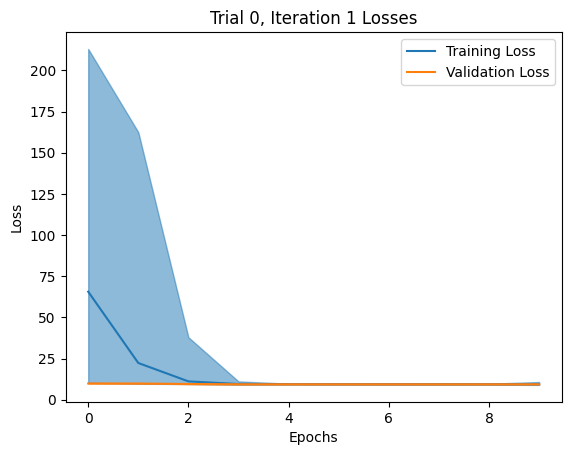

In [47]:
plt.plot(np.arange(0, NUM_EPOCHS), train_distiller.train_logger.avgs, label='Training Loss', color='tab:blue')
plt.fill_between(np.arange(0, NUM_EPOCHS), train_distiller.train_logger.mins, train_distiller.train_logger.maxs, color='tab:blue', alpha=0.5)

plt.plot(np.arange(0, NUM_EPOCHS), train_distiller.valid_logger.avgs, label='Validation Loss', color='tab:orange')
plt.fill_between(np.arange(0, NUM_EPOCHS), train_distiller.valid_logger.mins, train_distiller.valid_logger.maxs, color='tab:orange', alpha=0.5)

plt.title('Trial 0, Iteration 1 Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

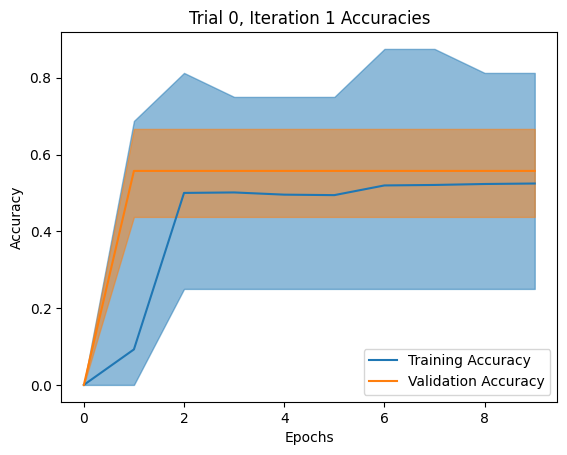

In [48]:
plt.plot(np.arange(0, NUM_EPOCHS), train_distiller.acc_train_logger.avgs, label='Training Accuracy', color='tab:blue')
plt.fill_between(np.arange(0, NUM_EPOCHS), train_distiller.acc_train_logger.mins, train_distiller.acc_train_logger.maxs, color='tab:blue', alpha=0.5)

plt.plot(np.arange(0, NUM_EPOCHS), train_distiller.acc_valid_logger.avgs, label='Validation Accuracy', color='tab:orange')
plt.fill_between(np.arange(0, NUM_EPOCHS), train_distiller.acc_valid_logger.mins, train_distiller.acc_valid_logger.maxs, color='tab:orange', alpha=0.5)

plt.title('Trial 0, Iteration 1 Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

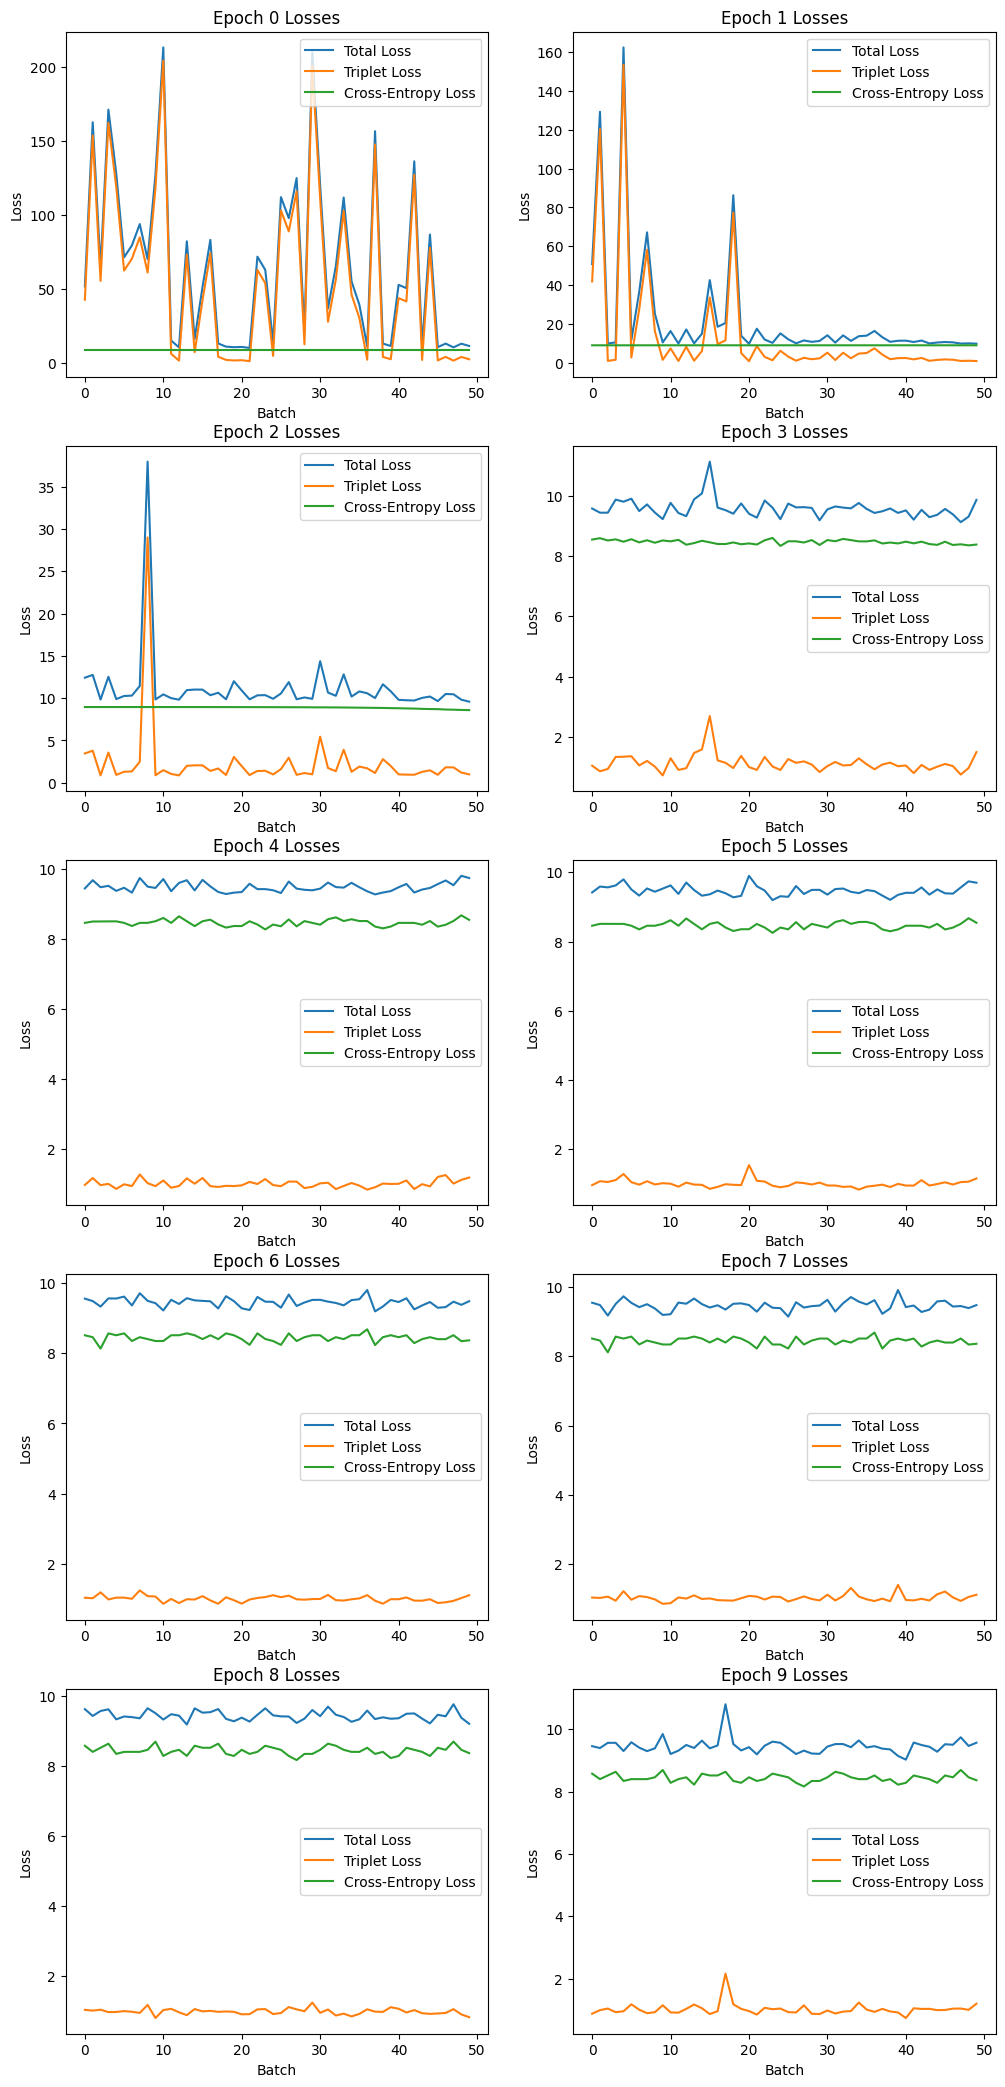

In [54]:
plt.figure(figsize=(12, 26))
for i in range(NUM_EPOCHS):
    plt.subplot(5, 2, i + 1)
    plt.plot(np.arange(0, len(train_distiller.train_intra_epoch_loggers[i].logs[0])), train_distiller.train_intra_epoch_loggers[i].logs[0], label='Total Loss', color='tab:blue')
    plt.plot(np.arange(0, len(train_distiller.train_intra_epoch_loggers[i].logs[1])), train_distiller.train_intra_epoch_loggers[i].logs[1], label='Triplet Loss', color='tab:orange')
    plt.plot(np.arange(0, len(train_distiller.train_intra_epoch_loggers[i].logs[2])), train_distiller.train_intra_epoch_loggers[i].logs[2], label='Cross-Entropy Loss', color='tab:green')
    
    plt.title(f'Epoch {i} Losses')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()